In [1]:
# ==============================================================================
# 1. CONFIGURAÇÃO DO AMBIENTE-
#Objetivo: import das bibliotecas que serão utilizadas no projeto
# ==============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [2]:
# ==============================================================================
# 2. CARGA DE DADOS E LIMPEZA INICIAL (ETL)
# Objetivo: Importar o dataset, verificar integridade e remover ruídos.
# ==============================================================================

# 1. Carregamento
df = None # Initialize df to None
try:
    # Corrected file extension from .cvs to .csv
    df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.xls')
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print("Erro: Arquivo não encontrado. Verifique o caminho ou o upload no Colab.")

if df is not None:
    # 2. Criação da Variável Alvo Numérica (Auxiliar)
    # Mantemos 'Attrition' (Yes/No) para gráficos e criamos 'Attrition_Num' (1/0) para cálculos
    if 'Attrition' in df.columns:
        df['Attrition_Num'] = df['Attrition'].map({'Yes': 1, 'No': 0})

    # 3. Limpeza de Colunas Inúteis (Redução de Ruído)
    # Elas não ajudam o modelo a diferenciar ninguém, então removemos.
    colunas_inuteis = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
    df = df.drop(columns=colunas_inuteis, errors='ignore')

    # 4. Verificação de Integridade (Sanity Check)
    # Verifica se há linhas duplicadas (remove se houver)
    df = df.drop_duplicates()

    print(f"\nDimensões Finais do Dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")

    # 5. Validação de Nulos
    # Exibe apenas colunas que tenham valores vazios (se nada aparecer, está perfeito)
    nulos = df.isnull().sum()
    print("\n--- Verificação de Valores Nulos ---")
    print(nulos[nulos > 0] if nulos.sum() > 0 else "Nenhum valor nulo encontrado.")

    #6. Definição de constantes de visualização dos gŕaficos
    # Tema base
    plt.style.use('seaborn-v0_8-whitegrid')

    #Paleta padrão do projeto
    COLOR_NO  = '#2A9D8F'
    COLOR_YES = '#E76F51'

    # Fonte padrão
    plt.rcParams.update({
        'figure.figsize': (7, 5),
        'axes.titlesize': 14,
        'axes.titleweight': 'bold',
        'axes.labelsize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })

    # Amostra final para garantir que tudo parece certo
    df.head()
else:
    print("Não foi possível carregar o dataset, as operações subsequentes foram ignoradas.")


Dataset carregado com sucesso!

Dimensões Finais do Dataset: 1470 linhas x 32 colunas

--- Verificação de Valores Nulos ---
Nenhum valor nulo encontrado.


Yes: Funcionários que saíram | No: Funcionários ativos


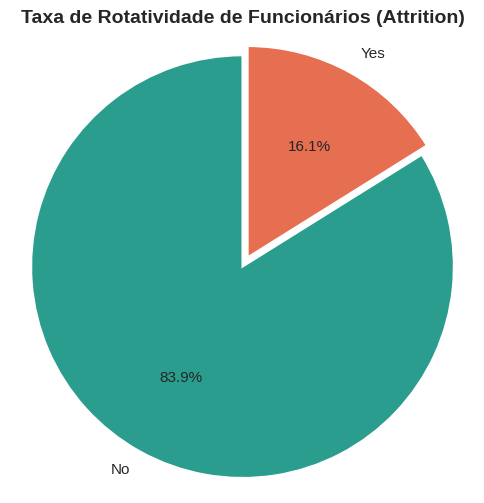

In [3]:
# ==============================================================================
# 3. ANÁLISE EXPLORÁTORIA
# Objetivo: Entender quais variáveis influenciam no desligamento dos funcionários
# ==============================================================================


# ==============================================================================
# 3.1. ANÁLISE DIMENSIONAL (O Tamanho do Problema)
# Objetivo: Entender a proporção de funcionários que saíram (Churn Rate)
# ==============================================================================

print("Yes: Funcionários que saíram | No: Funcionários ativos")

# Calculando a frequência relativa (%) de cada grupo
# normalize=True traz a proporção (0 a 1) e mul(100) converte para porcentagem
churn_rate = df['Attrition'].value_counts(normalize=True).mul(100).round(2)

# Visualização: Gráfico de Pizza
plt.figure(figsize=(6, 6))

plt.pie(
    churn_rate,
    labels=churn_rate.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[COLOR_NO, COLOR_YES],
    explode=(0.05, 0)     ,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 11}
)


plt.title(
    'Taxa de Rotatividade de Funcionários (Attrition)',
    fontsize=14,
    fontweight='bold'
)

plt.axis('equal')  # Mantém o gráfico redondo
plt.show()

--- Média Salarial por Grupo ---
Attrition
No     6832.739659
Yes    4787.092827
Name: MonthlyIncome, dtype: float64


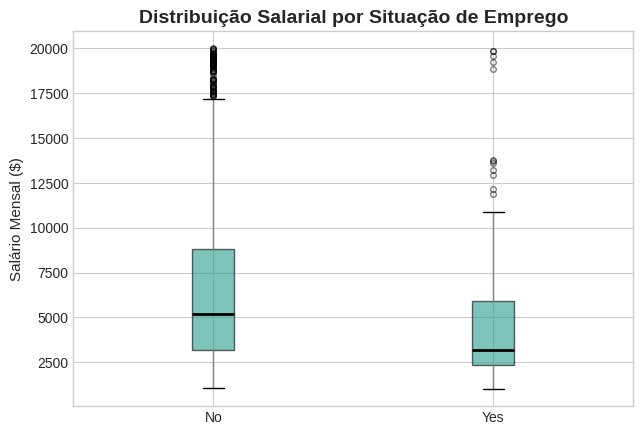

In [4]:
# ==============================================================================
# 3.2. ANÁLISE FINANCEIRA (Impacto do Salário)
# Objetivo: Verificar se quem ganha menos tende a sair mais
# ==============================================================================

# Comparação direta das médias salariais
print("--- Média Salarial por Grupo ---")
print(df.groupby('Attrition')['MonthlyIncome'].mean())

# Visualização: Boxplot (Ideal para ver a distribuição e outliers)
fig, ax = plt.subplots()


df.boxplot(
    column='MonthlyIncome',
    by='Attrition',
    ax=ax,
    patch_artist=True,
    boxprops=dict(facecolor=COLOR_NO, alpha=0.6),
    medianprops=dict(color='black', linewidth=2),
    whiskerprops=dict(color='gray'),
    flierprops=dict(marker='o', markersize=4, alpha=0.5)
)

ax.set_title('Distribuição Salarial por Situação de Emprego')
ax.set_ylabel('Salário Mensal ($)')
ax.set_xlabel('')
plt.suptitle('')
plt.show()

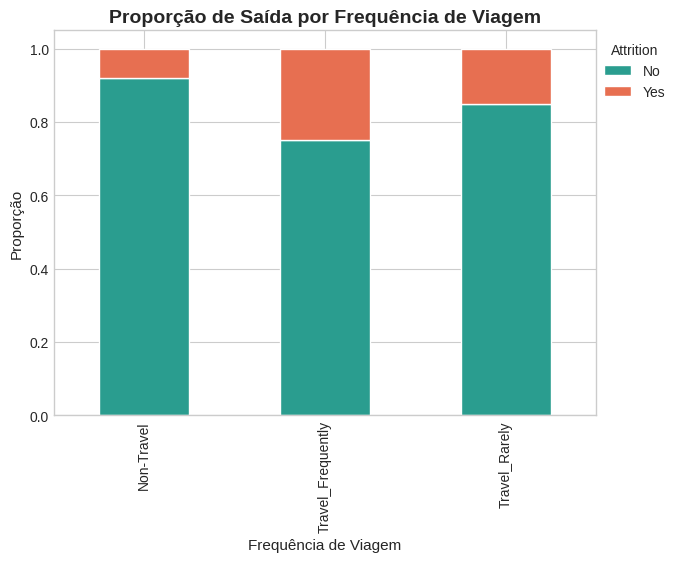

In [5]:
# ====================================================================================
# 3.3. ANÁLISE DE VIAGENS (Influência das viagens)
#Objetivo: Verificar a relação entre frequência de viagens e o desligamento da empresa
# ====================================================================================

#Cruzamento das variáveis
travel_attrition = pd.crosstab(
    df['BusinessTravel'],
    df['Attrition'],
    normalize='index'
)

#Visualização: Gráficos de barras empilhadas
travel_attrition[['No', 'Yes']].plot(
    kind='bar',
    stacked=True,
    color=[COLOR_NO, COLOR_YES],
    edgecolor='white'
)

plt.title('Proporção de Saída por Frequência de Viagem')
plt.ylabel('Proporção')
plt.xlabel('Frequência de Viagem')
plt.legend(title='Attrition', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.show()





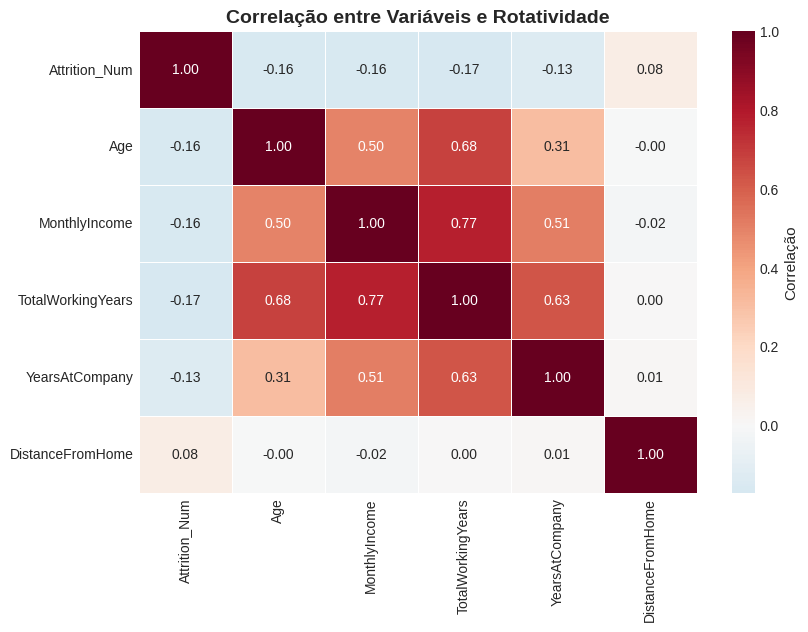

In [6]:
# ==============================================================================
# 3.4. ANÁLISE DE CORRELAÇÃO (O que influencia a saída?)
#Obejtivo: Analisar de forma mais abrange as variáveis
# ==============================================================================

colunas_analise = ['Attrition_Num', 'Age', 'MonthlyIncome',
                   'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome']
# Cálculo da Matriz
correlacao = df[colunas_analise].corr()

# Visualização: Heatmap
plt.figure(figsize=(9, 6))

sns.heatmap(
    correlacao,
    annot=True,
    cmap='RdBu_r',
    fmt='.2f',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlação'}
)

plt.title('Correlação entre Variáveis e Rotatividade')
plt.show()

--- Taxa de Saída por Faixa Etária ---
Attrition               No        Yes
Categoria_Idade                      
Jovem            60.824742  39.175258
Adulto           79.783394  20.216606
Senior           90.092879   9.907121
Veterano         86.705202  13.294798


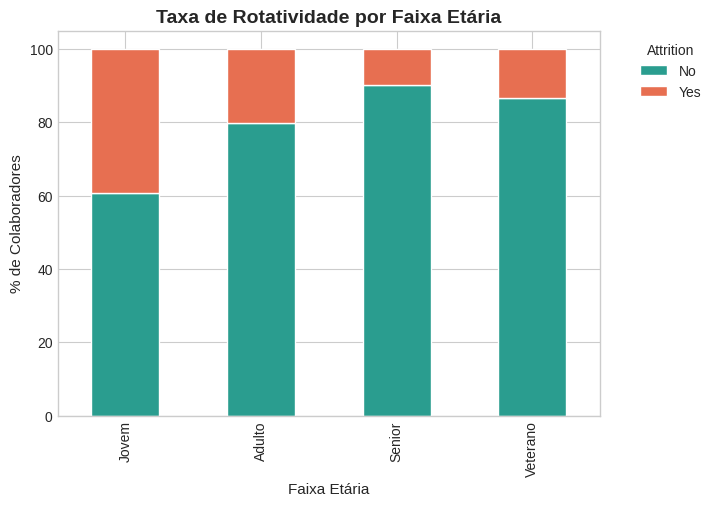

In [7]:
# ==============================================================================
# 3.5. ANÁLISE ETÁRIA (Verificar se jovens saem mais)
# Obejtivo: Validar analise de hotmap e verificar as categorias etárias que mais
# saem da empresa
# ==============================================================================

# Definindo bins e labels
# 18-25: Jovem | 26-35: Adulto | 36-50: Senior | 50+: Veterano

bins = [18, 25, 35, 50, float('inf')]
labels = ['Jovem', 'Adulto', 'Senior', 'Veterano']

# Criando uam nova coluna de categoria
df['Categoria_Idade'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Verificando a taxa de sáida por essa categoria
churn_idade = pd.crosstab(df['Categoria_Idade'], df['Attrition'], normalize='index') * 100

print("--- Taxa de Saída por Faixa Etária ---")
print(churn_idade)

# Visualização: grafíco de barras empilhadas
churn_idade[['No', 'Yes']].plot(
    kind='bar',
    stacked=True,
    color=[COLOR_NO, COLOR_YES],
    edgecolor='white'
)

plt.title('Taxa de Rotatividade por Faixa Etária')
plt.ylabel('% de Colaboradores')
plt.xlabel('Faixa Etária')
plt.legend(title='Attrition', bbox_to_anchor=(1.05, 1))
plt.show()


In [8]:
# ==============================================================================
# 4. PRÉ-PROCESSAMENTO PARA MACHINE LEARNING
# Objetivo: Transformar textos em números e colocar tudo na mesma escala (0 a 1)
# ==============================================================================

# Definição das colunas numéricas que precisam de escala
colunas_para_escalar = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome']

# ENCODING: Transformar categóricas (Texto) em Numéricas
# drop_first=True: Remove a primeira opção para evitar redundância (Multicolinearidade)
df_final = pd.get_dummies(df, columns=['Department', 'Gender', 'BusinessTravel'], drop_first=True)

# SCALING: Colocar números grandes e pequenos na mesma régua
# Criando o objeto "Escalador"
scaler = MinMaxScaler()

# Aplicando a transformação APENAS nas colunas numéricas do nosso df_final
df_final[colunas_para_escalar] = scaler.fit_transform(df_final[colunas_para_escalar])

# Validação (Quality Assurance)
print("--- Verificação do Pré-Processamento ---")
print("1. Colunas Numéricas Escaladas (Ex: Age):")
print(df_final[['Age', 'MonthlyIncome']].head(3))

print("\n2. Novas Colunas Criadas (Dummies):")
# Mostra colunas que contêm 'Department' no nome para ver se funcionou
cols_dummies = [col for col in df_final.columns if 'Department' in col]
print(df_final[cols_dummies].head(3))

# Definição das Features para o Modelo
colunas_para_modelo = colunas_para_escalar + cols_dummies


--- Verificação do Pré-Processamento ---
1. Colunas Numéricas Escaladas (Ex: Age):
        Age  MonthlyIncome
0  0.547619       0.262454
1  0.738095       0.217009
2  0.452381       0.056925

2. Novas Colunas Criadas (Dummies):
   Department_Research & Development  Department_Sales
0                              False              True
1                               True             False
2                               True             False


In [9]:
# ==============================================================================
# 5. PREPARAÇÃO PARA MODELAGEM (Split de Treino e Teste)
# Objetivo: Separar os dados para garantir que os modelos sejam comparáveis
# ==============================================================================

# 1. Definição de Variáveis
# X = As Perguntas (Features) | y = O Gabarito (Target)
X = df_final[colunas_para_modelo]
y = df['Attrition_Num']

# 2. Divisão (Holdout)
# Estratégia: 75% para a IA estudar (Train) e 25% para a prova final (Test)
# stratify=y garante que a proporção de "Sim/Não" seja igual no treino e no teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("--- Divisão Concluída ---")
print(f"Treino: {X_train.shape[0]} funcionários | Teste: {X_test.shape[0]} funcionários")

--- Divisão Concluída ---
Treino: 1102 funcionários | Teste: 368 funcionários


--- Performance: Regressão Logística ---
Acurácia: 62.23%

Relatório Detalhado:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       309
           1       0.23      0.58      0.33        59

    accuracy                           0.62       368
   macro avg       0.56      0.60      0.53       368
weighted avg       0.78      0.62      0.67       368



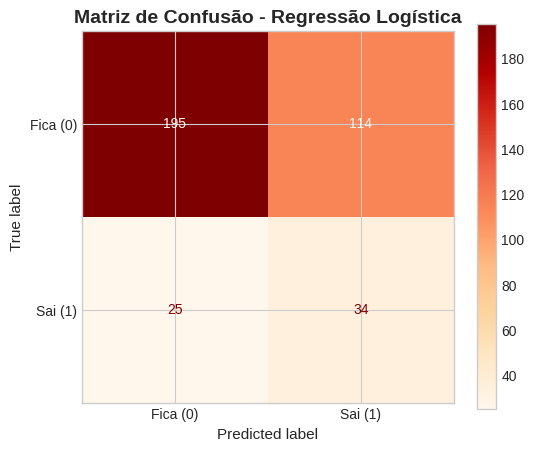

In [10]:
# ==============================================================================
# 5.1. MODELO A: REGRESSÃO LOGÍSTICA
# Objetivo: Modelo base (Baseline) explicável e simples
# ==============================================================================

# Treinamento
# class_weight='balanced': Dá mais peso para quem sai (ajuda a corrigir o desbalanceamento)
model_log = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_log.fit(X_train, y_train)

# Previsão
y_pred_log = model_log.predict(X_test)

# Métricas
print("--- Performance: Regressão Logística ---")
acuracia = accuracy_score(y_test, y_pred_log)
print(f"Acurácia: {acuracia:.2%}")
print("\nRelatório Detalhado:")
print(classification_report(y_test, y_pred_log, zero_division=0))

# Visualização: Matriz de Confusão
# Mostra visualmente onde o modelo acertou e onde errou
cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fica (0)', 'Sai (1)'])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='OrRd', ax=ax, values_format='d')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

--- Performance: Random Forest ---
Acurácia: 82.07%

Relatório Detalhado:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       309
           1       0.29      0.08      0.13        59

    accuracy                           0.82       368
   macro avg       0.57      0.52      0.52       368
weighted avg       0.76      0.82      0.78       368



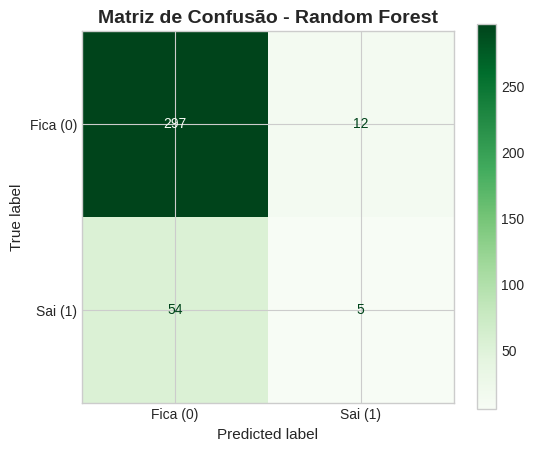

In [11]:
# ==============================================================================
# 5.2. MODELO B: RANDOM FOREST (FLORESTA ALEATÓRIA)
# Objetivo: Modelo mais robusto para capturar padrões complexos
# ==============================================================================

# Treinamento
# n_estimators=100: Cria 100 árvores para votar
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Previsão
y_pred_rf = rf_model.predict(X_test)

# Métricas
print("--- Performance: Random Forest ---")
acuracia_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia: {acuracia_rf:.2%}")
print("\nRelatório Detalhado:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Visualização: Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Fica (0)', 'Sai (1)'])

fig, ax = plt.subplots(figsize=(6, 5))
disp_rf.plot(cmap='Greens', ax=ax, values_format='d') # Mudei para verde para diferenciar
plt.title('Matriz de Confusão - Random Forest')
plt.show()

/tmp/ipython-input-1295222211.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


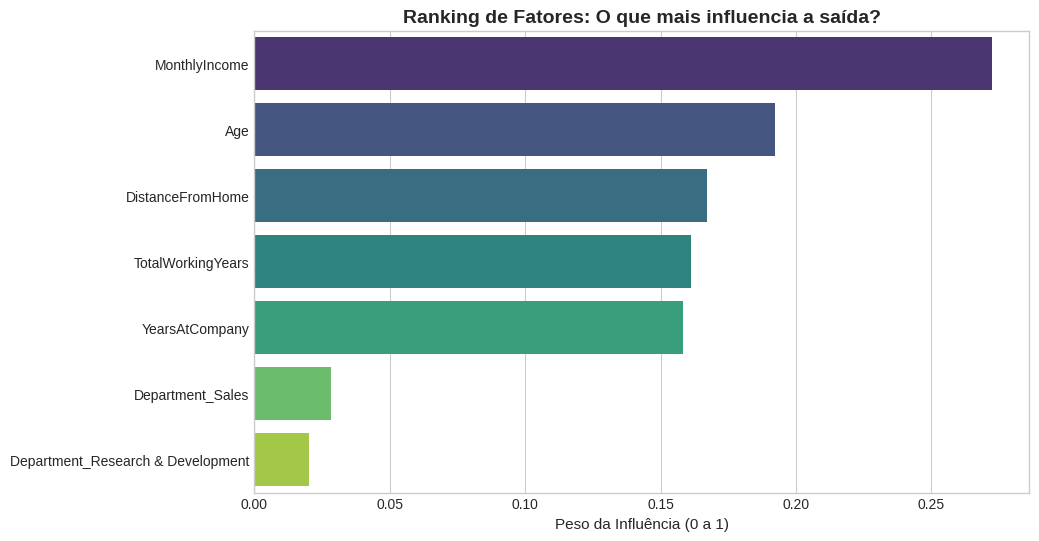

In [12]:

# 1. Extraindo a "nota" de importância que o modelo deu para cada coluna
importancias = rf_model.feature_importances_

# 2. Organizando em uma tabela (DataFrame) para facilitar o gráfico
# Usamos X_train.columns para pegar os nomes das colunas na ordem certa
df_imp = pd.DataFrame({
    'Variavel': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False) # Ordena do mais importante para o menos

# 3. Gerando o Gráfico de Barras
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_imp,
    x='Importancia',
    y='Variavel',
    palette='viridis'
)

plt.title('Ranking de Fatores: O que mais influencia a saída?')
plt.xlabel('Peso da Influência (0 a 1)')
plt.ylabel('')
plt.show()

In [13]:
# ==============================================================================
# 6. CONCLUSÃO E SIMULAÇÃO (DEPLOYMENT)
# Objetivo: Simular o modelo em ação com um caso real (Storytelling)
# ==============================================================================


# 1. PERFIL DO FUNCIONÁRIO "JOÃO" (Cenário de Risco)
# Vamos criar um funcionário fictício com características críticas
# Nota: Para as colunas de texto (Dummies), precisamos definir manualmente
# ------------------------------------------------------------------------------
novo_funcionario = {
    'Age': 29,                    # Jovem
    'MonthlyIncome': 2500,        # Salário Baixo (Fator Crítico!)
    'TotalWorkingYears': 4,       # Pouca experiência geral
    'YearsAtCompany': 2,          # Pouco tempo de casa
    'DistanceFromHome': 25,       # Mora longe
    # Colunas Dummies (Binárias: 0 ou 1)
    # Supondo que ele é de Vendas (Department_Sales = 1) e Homem (Gender_Male = 1)
    'Department_Sales': 1,
    'Gender_Male': 1,
    'BusinessTravel_Travel_Frequently': 0 # Não viaja muito
}

# 2. PREPARAÇÃO DOS DADOS (Alinhamento com o Treino)
# Criamos um DataFrame vazio com AS MESMAS colunas que o modelo aprendeu (X_train)
# Isso evita erro de "shape mismatch" (diferença de colunas)
df_simulacao = pd.DataFrame(columns=X_train.columns)

# Adicionamos os dados do João (o que não for preenchido vira 0 ou NaN)
df_simulacao.loc[0] = pd.Series(novo_funcionario)

# Preenchemos colunas faltantes com 0 (ex: Department_Research que ele não é)
df_simulacao = df_simulacao.fillna(0)

# 3. ESCALONAMENTO (O Passo Crucial)
# Devemos usar o MESMO "scaler" treinado no Bloco 4.
# Se usarmos um novo scaler, os números ficarão errados.
cols_numericas = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'DistanceFromHome']
df_simulacao[cols_numericas] = scaler.transform(df_simulacao[cols_numericas])

# 4. PREVISÃO (A Inteligência Artificial)
# Usando o Random Forest (rf_model) que costuma ser o melhor
previsao = rf_model.predict(df_simulacao)
probabilidade = rf_model.predict_proba(df_simulacao)

# 5. RESULTADO FINAL (Tradução para Negócios)
prob_sair = probabilidade[0][1] # Pega a probabilidade da classe 1 (Sair)

print("---  Relatório de Previsão de Churn ---")
print(f"Funcionário: João (29 anos, R$ 2.500, Vendas)")
print("-" * 40)

if prob_sair > 0.5:
    status = "ALTO RISCO DE SAÍDA "
    acao = "Sugerir revisão salarial ou conversa de carreira urgente."
else:
    status = "BAIXO RISCO (Retenção Provável) "
    acao = "Manter monitoramento padrão."

print(f"Veredito do Modelo: **{status}**")
print(f"Probabilidade Calculada: {prob_sair:.2%}")
print(f"Ação Recomendada: {acao}")

---  Relatório de Previsão de Churn ---
Funcionário: João (29 anos, R$ 2.500, Vendas)
----------------------------------------
Veredito do Modelo: **BAIXO RISCO (Retenção Provável) **
Probabilidade Calculada: 26.00%
Ação Recomendada: Manter monitoramento padrão.



INSIGTS

*  Os funcionarios que mais viajavam foram os que mais sairam da empresa, isso pode indicar excesso de trabalho como um fator para a solicitação de desligamento da empresa.

*  O mapa de calor indica que nenhuma variável apresenta correlação forte com a saída de funcionários (Attrition). As maiores correlações negativas, embora fracas, ocorrem com idade, renda mensal e anos totais de trabalho, sugerindo que funcionários mais jovens, com menor salário e menos experiência tendem levemente a sair mais. A variável DistanceFromHome não apresenta relação significativa com Attrition.”

*   Funcionários mais jovens (especialmente abaixo de 30 anos) e com menos tempo de carreira têm uma rotatividade muito maior. Criar programas de retenção específicos para "Jovens Talentos" ou Planos de Carreira mais claros para quem está começando, pois é onde a sangria é maior.






